In [1]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from keras import Input, Model
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords_list = stopwords.words('english')
tokenizer = wordpunct_tokenize


nlp = spacy.load('en_core_web_sm')

lst = ['no', 'not', 'nor', 'very', 'too', 'ain\'', 'ain\'t']
stopwords_list = [s for s in stopwords_list if s not in lst]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leeladhar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/leeladhar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
TOTAL_LEN = 2048
BATCH_SIZE = 32

In [4]:
import contractions

In [5]:
def get_data_dic(folder):
    y = list()
    x = list()
    data = dict()
    base_path = os.path.join('/home/leeladhar/Documents/sentiment_data', folder)
    for path in os.listdir(base_path):
        for files in [os.path.join(base_path, path,f) for f in os.listdir(os.path.join(base_path, path))]:
            file = open(files, 'r').read()
            x.append(file)
            if path == 'neg':
                y.append(0)
            elif path == 'pos':
                y.append(1)

    data['text'] = x
    data['sentiment'] = y
    return pd.DataFrame(data).sample(frac=1).reset_index(drop=True)        

In [6]:
train_df = get_data_dic('train')
test_df = get_data_dic('test')

In [7]:
print(train_df.shape)
train_df.head()

(35769, 2)


,text,sentiment
0,the lowest score possible is one star? that's ...,0
1,"""The Love Letter"" is a somewhat pleasant, very...",1
2,Until today I had never seen this film. Its wa...,1
3,and anyone who watches this film will agree. T...,1
4,For anyone who's judged others at first meetin...,1


In [8]:
print(test_df.shape)
test_df.head()

(10000, 2)


,text,sentiment
0,Ghilli is the best movie of vijay & one of the...,1
1,this movie is honestly the worst piece of rubb...,0
2,This movie is bad as we all knew it would be. ...,0
3,The Director loves the actress and it shows. T...,1
4,This is the worst exercise in middle class pre...,0


In [9]:
def process_data_text(text,
                     html_tag_remove=True,
                     contraction=True,
                     remove_spcl_char=True,
                     remove_punct=True,
                     remove_newline_char=True,
                     root_word='lemm',
                     remove_stopword=True,
                     remove_extra_space=True,
                     to_lower=True):
    
    
    if html_tag_remove:
        text = BeautifulSoup(text, 'html.parser').get_text()
    if contraction:
        text = contractions.fix(text)
    if remove_spcl_char:
        text = re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', text)
    if remove_punct:
        text = ''.join([c for c in text if c not in string.punctuation])
    if remove_newline_char:
        text = text.replace('\n', ' ')
    if root_word=='lemm':
        text = nlp(text)
        text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    elif root_word == 'stem':
        text = nltk.porter.PorterStemmer()
        text = ' '.join([stemmer.stem(word) for word in text.split()])
    else:
        raise Exception('Root Word is wrong.')
    if remove_stopword:
        tokens = tokenizer(text)
        tokens = [token.strip() for token in tokens]
        tok = [token for token in tokens if token.lower() not in stopwords_list]
        text = ' '.join(tok)
    if remove_extra_space:
        text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
    if to_lower:
        text = text.lower()
    return text

In [10]:
test_df['text'] = test_df['text'].apply(lambda x: process_data_text(x))

In [11]:
def corpus_gen():
    for i, row in train_df.iterrows():
        yield row['text']

tokenizer_sentiment = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_gen(), target_vocab_size=2**13)
tokenizer_sentiment.save_to_file('sentiment')

In [12]:
tokenizer_sentiment = tfds.deprecated.text.SubwordTextEncoder.load_from_file('sentiment')

In [13]:
def encoding_and_padding(text):
    en_text = [tokenizer_sentiment.vocab_size] + tokenizer_sentiment.encode(text)
    if len(en_text) < TOTAL_LEN:
        en_text = en_text + [0] * (TOTAL_LEN - len(en_text) - 1) + [tokenizer_sentiment.vocab_size + 1]
    else:
        en_text = en_text[:TOTAL_LEN-1] + [tokenizer_sentiment.vocab_size + 1]
    return en_text

In [14]:
def get_data_x_y(df):
    x = np.asarray([r['encoded_text'] for i, r in df.iterrows()])
    y = np.asarray(df['sentiment'])
    return x, y

In [15]:
train_df['encoded_text'] = train_df['text'].apply(lambda x: encoding_and_padding(x))
train_df.drop('text', axis=1, inplace=True)
train_df.head()

,sentiment,encoded_text
0,0,"[8160, 1, 900, 631, 1359, 1640, 9, 45, 884, 87..."
1,1,"[8160, 7938, 19, 3987, 2214, 590, 54, 9, 4, 10..."
2,1,"[8160, 908, 4071, 7936, 3275, 12, 82, 140, 166..."
3,1,"[8160, 5, 400, 46, 3334, 8, 14, 33, 96, 3404, ..."
4,1,"[8160, 377, 400, 530, 7943, 8, 3011, 38, 942, ..."


In [16]:
test_df['encoded_text'] = test_df['text'].apply(lambda x: encoding_and_padding(x))
test_df.drop('text', axis=1, inplace=True)
test_df.head()

,sentiment,encoded_text
0,1,"[8160, 1164, 1212, 128, 75, 27, 2702, 718, 47,..."
1,0,"[8160, 27, 4620, 133, 630, 5167, 7936, 163, 86..."
2,0,"[8160, 27, 133, 160, 71, 100, 960, 171, 133, 1..."
3,1,"[8160, 295, 171, 1298, 189, 1298, 7498, 284, 1..."
4,0,"[8160, 133, 4011, 6682, 540, 1482, 1574, 4743,..."


In [17]:
def model_data_gen(df):
    while True:
        df_sample = df.sample(n=BATCH_SIZE)
        x, y = get_data_x_y(df_sample)
        yield x, y

In [18]:
p, q = next(model_data_gen(train_df))

In [19]:
print('Text Batch Sequence Shape: ', p.shape)
print('Corresponding Sentiment Batch Shape: ', q.shape)

Text Batch Sequence Shape:  (32, 2048)
Corresponding Sentiment Batch Shape:  (32,)


In [20]:
train_gen = model_data_gen(train_df)
val_gen = model_data_gen(test_df)

In [21]:
VOCAB_SIZE = tokenizer_sentiment.vocab_size + 2
EMB_SIZE = 128

In [22]:
inputs = Input((TOTAL_LEN))
x = Embedding(VOCAB_SIZE, EMB_SIZE)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation="sigmoid")(x)

model_lstm = Model(inputs, outputs)

model_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2048, 128)         1044736   
_________________________________________________________________
bidirectional (Bidirectional (None, 2048, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [23]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
lr_red = ReduceLROnPlateau(patience=3, factor=0.01, monitor='val_accuracy')

In [25]:
hist = model_lstm.fit(train_gen, epochs=100, steps_per_epoch=64, validation_data=val_gen,
                      validation_steps=64, callbacks=[early_stop, lr_red])

Epoch 1/100
64/64 [==============================] - 213s 3s/step - loss: 0.6936 - accuracy: 0.5102 - val_loss: 0.6956 - val_accuracy: 0.4854
Epoch 2/100
64/64 [==============================] - 196s 3s/step - loss: 0.6926 - accuracy: 0.5247 - val_loss: 0.6170 - val_accuracy: 0.6758
Epoch 3/100
64/64 [==============================] - 195s 3s/step - loss: 0.6738 - accuracy: 0.6062 - val_loss: 0.5784 - val_accuracy: 0.7129
Epoch 4/100
64/64 [==============================] - 196s 3s/step - loss: 0.5724 - accuracy: 0.7142 - val_loss: 0.6321 - val_accuracy: 0.6689
Epoch 5/100
64/64 [==============================] - 195s 3s/step - loss: 0.5656 - accuracy: 0.7306 - val_loss: 0.5274 - val_accuracy: 0.7422
Epoch 6/100
64/64 [==============================] - 198s 3s/step - loss: 0.5400 - accuracy: 0.7597 - val_loss: 0.5595 - val_accuracy: 0.7588
Epoch 7/100
64/64 [==============================] - 195s 3s/step - loss: 0.4996 - accuracy: 0.7856 - val_loss: 0.5215 - val_accuracy: 0.7349
Epoch 

In [26]:
model_lstm.save('model_lstm.h5')

In [27]:
def res(result):
    if result > 0.5:
        print('positive')
    else:
        print('negative')

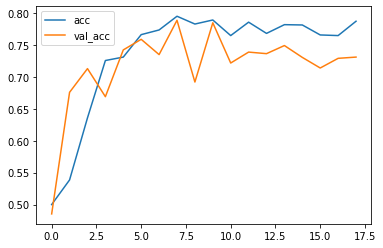

In [28]:
p1 = plt.plot(range(len(hist.history['accuracy'])), hist.history['accuracy'])
p2 = plt.plot(range(len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

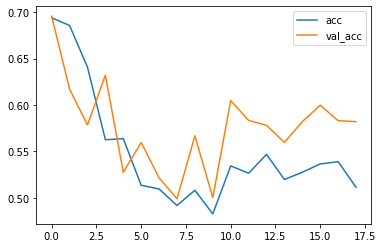

In [29]:
p1 = plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
p2 = plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'])
plt.legend(['acc', 'val_acc'])
plt.show()